In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf
import datetime, os
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 10 09:16:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Final project/myntradataset/"
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


In [8]:
# what is inside the main directory
list_directory = os.listdir(DATASET_PATH)
print(list_directory)

# each time directory files gets reordered. That's why needed to find where images folder is.
index=0
for i in range (len(list_directory)):
    if list_directory[i]=="images":
        index=i
        break

['styles.csv', 'images']


In [9]:
# what is in the image directory
imageIndex = os.listdir(DATASET_PATH+list_directory[index])
# print(type(imageIndex))
head = 12


In [11]:
# collecting some samples in list
sampleImages = []

In [12]:
# showing indices
for i in range (head):
    sampleImages.append(imageIndex[i])
    print(sampleImages[i])

9158.jpg
8966.jpg
9354.jpg
8909.jpg
8050.jpg
9517.jpg
9370.jpg
8741.jpg
8472.jpg
8017.jpg
8690.jpg
8981.jpg


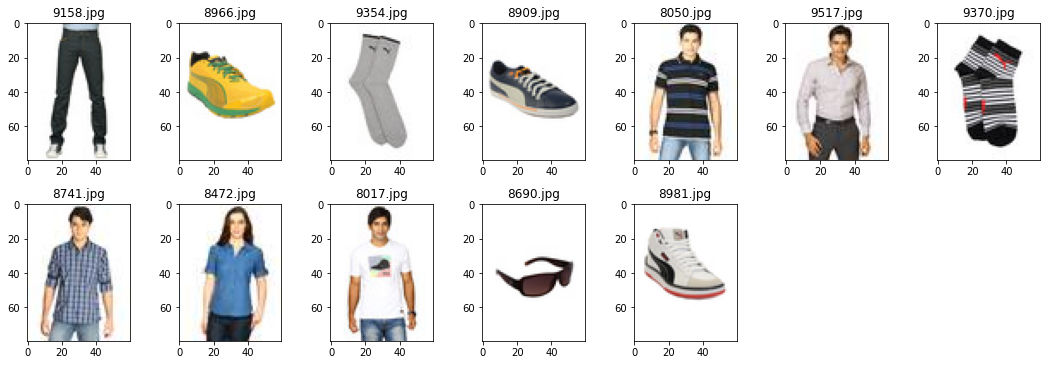

In [13]:

# choosing some samples to observe
fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
axis=[]
row = len(sampleImages)/2
col = row+1

for i in range (len(sampleImages)):
    Image_path=DATASET_PATH+list_directory[index]+"/"+sampleImages[i]
    src = cv2.imread(Image_path)
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
    axis.append(fig.add_subplot(row, col, i+1))
    subplot_title=sampleImages[i]
    axis[-1].set_title(subplot_title)  
    plt.imshow(image)

fig.tight_layout()
plt.show()

In [14]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=44000, error_bad_lines=False)
df.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 1

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [ ]:
# df['path'] = df.apply(lambda row: str( "/content/drive/MyDrive/Colab Notebooks/Final project/myntradataset/images/" + row['id'] + ".jpg"), axis=1)

In [15]:
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44000 entries, 0 to 43999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44000 non-null  int64  
 1   gender              44000 non-null  object 
 2   masterCategory      44000 non-null  object 
 3   subCategory         44000 non-null  object 
 4   articleType         44000 non-null  object 
 5   baseColour          43986 non-null  object 
 6   season              43979 non-null  object 
 7   year                43999 non-null  float64
 8   usage               43687 non-null  object 
 9   productDisplayName  43993 non-null  object 
 10  image               44000 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [17]:
# df = df.sample(frac=1).reset_index(drop=True)
# df

In [18]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
43995,50154,Women,Footwear,Shoes,Heels,Beige,Winter,2012.0,Casual,Rocia Women Beige Leopard Print Heels,50154.jpg
43996,34411,Men,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Casual,Myntra Men Master Of Ceremonies Black T-shirt,34411.jpg
43997,44766,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Globalite Men Black & Grey Eclipse Shoes,44766.jpg
43998,37294,Men,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,CASIO Enticer Men White Dial Analogue Watch A485,37294.jpg


In [19]:
df.shape

(44000, 11)

In [20]:
len(pd.unique(df['year']))

14

In [21]:
df.year.unique()

array([2011., 2012., 2016., 2017., 2015., 2014., 2010., 2013., 2018.,
       2019., 2007., 2009., 2008.,   nan])

In [22]:
df.duplicated().sum()

0

In [23]:
df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             14
season                 21
year                    1
usage                 313
productDisplayName      7
image                   0
dtype: int64

In [24]:
shortDataframe = pd.DataFrame({
    'filename': df['image'],
    'type': df['articleType']
})

# total number of entries in the dataframe
total_row = len(shortDataframe)
print('total row count: ', total_row)

shortDataframe.head(10)

total row count:  44000


,filename,type
0,15970.jpg,Shirts
1,39386.jpg,Jeans
2,59263.jpg,Watches
3,21379.jpg,Track Pants
4,53759.jpg,Tshirts
5,1855.jpg,Tshirts
6,30805.jpg,Shirts
7,26960.jpg,Shirts
8,29114.jpg,Socks
9,30039.jpg,Watches


In [25]:
unique_types = shortDataframe['type'].unique().tolist()
total_class = len(unique_types)
print(total_class)
print(unique_types)
print(unique_types[0])
print(unique_types.index(unique_types[0]))
shortDataframe['number_types'] = shortDataframe['type'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
shortDataframe.head(10)

143
['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks', 'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra', 'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant', 'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas', 'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees', 'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests', 'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket', 'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring', 'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers', 'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta', 'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics', 'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser', 'Necklace and Chains', 'Duffel Bag', 'Sports Sandals', 'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag', 'Tracksuits', 'Swimwear', 'Shoe Laces', 'Fragrance Gift Set', 'Bangle', 'Nightdress', 'Ties', 'Baby Dolls', 'Legging

,filename,type,number_types
0,15970.jpg,Shirts,0
1,39386.jpg,Jeans,1
2,59263.jpg,Watches,2
3,21379.jpg,Track Pants,3
4,53759.jpg,Tshirts,4
5,1855.jpg,Tshirts,4
6,30805.jpg,Shirts,0
7,26960.jpg,Shirts,0
8,29114.jpg,Socks,5
9,30039.jpg,Watches,2


In [26]:
shortDataframe.number_types.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142])

In [27]:
shortDataframe['type'].value_counts()

Tshirts                6993
Shirts                 3190
Casual Shoes           2813
Watches                2518
Sports Shoes           2012
                       ... 
Shoe Laces                1
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Ipad                      1
Name: type, Length: 143, dtype: int64

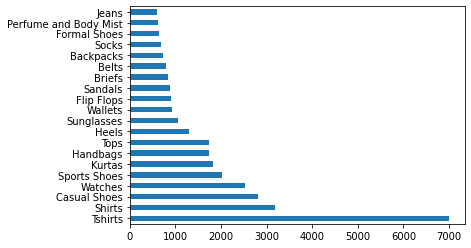

In [28]:
shortDataframe['type'].value_counts()[:20].plot(kind='barh')

In [29]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


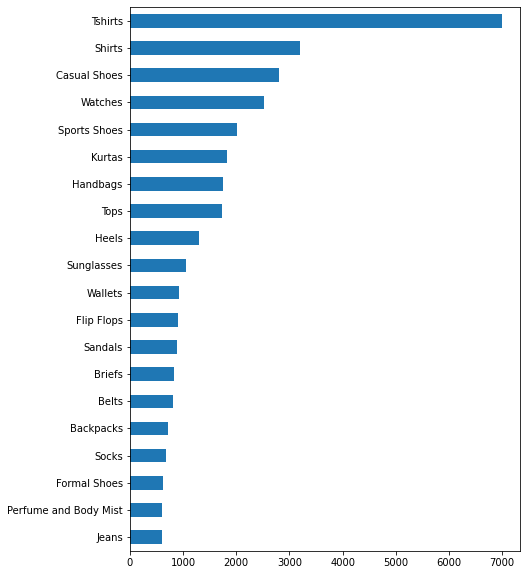

In [30]:
plt.figure(figsize=(7,10))
df.articleType.value_counts().sort_values()[123:143].plot(kind='barh')

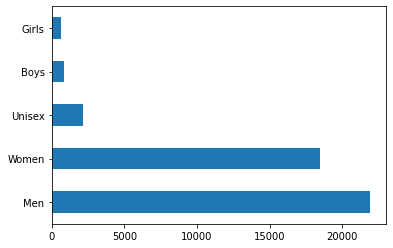

In [31]:
df['gender'].value_counts()[:5].plot(kind='barh')

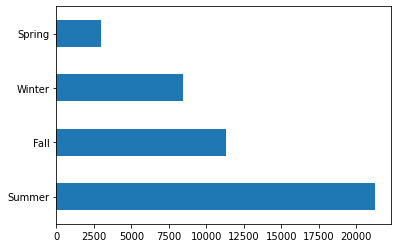

In [32]:
df['season'].value_counts()[:5].plot(kind='barh')

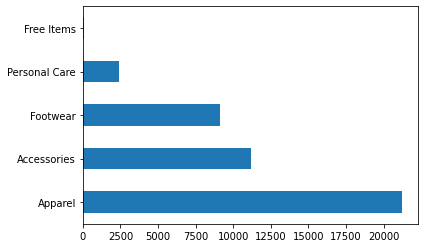

In [33]:
df['masterCategory'].value_counts()[:5].plot(kind='barh')


In [34]:
df['usage'].value_counts()

Casual          34079
Sports           3979
Ethnic           3182
Formal           2324
Smart Casual       67
Party              29
Travel             26
Home                1
Name: usage, dtype: int64

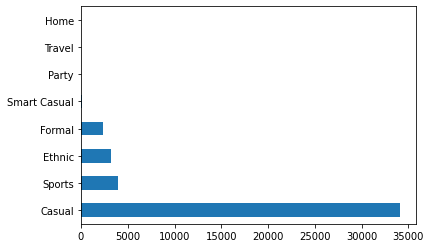

In [35]:
df['usage'].value_counts()[:20].plot(kind='barh')

In [36]:
df['baseColour'].value_counts()[:20]

Black        9645
White        5487
Blue         4863
Brown        3458
Grey         2725
Red          2428
Green        2099
Pink         1840
Navy Blue    1774
Purple       1621
Silver       1084
Yellow        769
Beige         742
Gold          622
Maroon        573
Orange        524
Olive         403
Multi         389
Cream         383
Steel         312
Name: baseColour, dtype: int64

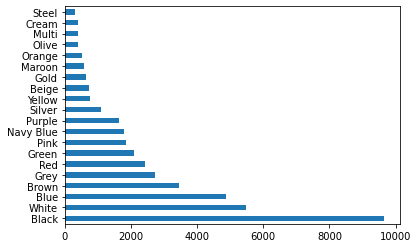

In [37]:
df['baseColour'].value_counts()[:20].plot(kind='barh')

In [38]:
def getData(start,stop):
    x_data = []
    y_data = []
    #start = 0 #setting start parameter
    #stop = int(0.001*total_row) #setting stop parameter 
    
    for i in range(start, stop): 
        Image_path=DATASET_PATH+list_directory[index]+"/"+shortDataframe.loc[i,'filename']
#         print(shortDataframe.loc[i,'filename'])
        image = cv2.imread(Image_path,cv2.IMREAD_GRAYSCALE) #always convert image to the single channel grayscale image (codec internal conversion).
        try:
            resized_img = cv2.resize(image, dsize=(150, 150))
        except:
            print("Rejected Image: "+shortDataframe.loc[i,'filename'])
            continue
        x_data.append(resized_img) 
        y_values = shortDataframe.loc[i,'number_types'] # earlier it was type
        y_data.append(y_values)
                
    return x_data, y_data

In [39]:
X=[]
Y=[]
# for now start=0,stop=(0.001*total_row)
# total_row=count of rows in augmented data frame
start = 0
stop = int(0.005*total_row) # testing with 0.1% image of the dataset
X,Y=getData(start,stop)

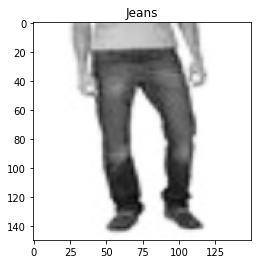

In [40]:
# print(type(X))
# print(X[0])
plt.title(unique_types[Y[1]])
plt.imshow(X[1], cmap='Greys_r')


In [41]:
X = np.array(X).reshape(-1, 150,150,1)
Y = np.array(Y)

In [42]:
X = X/255.0

In [43]:
Y = Y.reshape(len(X),)

In [44]:
print(type(X))
print(X.shape)
print(Y.shape)
# print(X[0])
# print(Y[0])

<class 'numpy.ndarray'>
(220, 150, 150, 1)
(220,)


In [45]:
X_All=[]
Y_All=[]
start = 0
stop = total_row
X_All,Y_All=getData(start,stop)

Rejected Image: 39403.jpg
Rejected Image: 39410.jpg
Rejected Image: 39401.jpg
Rejected Image: 39425.jpg
Rejected Image: 12347.jpg


In [46]:
# conversion into numpy array
X_All = np.array(X_All).reshape(-1, 150,150,1)
Y_All = np.array(Y_All)

In [47]:
# normalizing
X_All = X_All/255

In [48]:

# processing Y_train for dimension matching
Y_All = Y_All.reshape(len(X_All),)

In [49]:
print('Image Data Shape: ',X_All.shape)
print('Label Data Shape: ',Y_All.shape)

Image Data Shape:  (43995, 150, 150, 1)
Label Data Shape:  (43995,)


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X_All, Y_All, test_size = 0.1, random_state = 500)

In [52]:
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Test Image Data Shape: ',X_test.shape)
print('Test Label Data Shape: ',Y_test.shape)

Train Image Data Shape:  (39595, 150, 150, 1)
Train Label Data Shape:  (39595,)
Test Image Data Shape:  (4400, 150, 150, 1)
Test Label Data Shape:  (4400,)


In [53]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 500)

In [54]:
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Validation Image Data Shape: ',X_validate.shape)
print('Validation Label Data Shape: ',Y_validate.shape)

Train Image Data Shape:  (35635, 150, 150, 1)
Train Label Data Shape:  (35635,)
Validation Image Data Shape:  (3960, 150, 150, 1)
Validation Label Data Shape:  (3960,)


In [55]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# import os
# import tensorflow as tf
# import datetime, os
# from tensorflow.keras.callbacks import TensorBoard

# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.xception import decode_predictions

In [56]:
def build_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), input_shape = (150,150,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(64, (3, 3), input_shape = (150,150,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(128, (3, 3), input_shape = (150,150,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(units = 512, activation = 'relu'))
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Dense(units = total_class, activation = 'softmax'))
    return cnn_model

In [57]:
model=build_model()

In [58]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [59]:
def train_model(model):
    model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_validate, Y_validate))
#     model.fit(X_train, Y_train, epochs=50, batch_size=512, validation_split=0.2)



In [60]:
train_model(model)

Epoch 1/10
279/279 [==============================] - 28s 59ms/step - loss: 2.2159 - accuracy: 0.4621 - val_loss: 1.1418 - val_accuracy: 0.6937
Epoch 2/10
279/279 [==============================] - 15s 55ms/step - loss: 1.0329 - accuracy: 0.7061 - val_loss: 0.8495 - val_accuracy: 0.7523
Epoch 3/10
279/279 [==============================] - 15s 55ms/step - loss: 0.8176 - accuracy: 0.7592 - val_loss: 0.7442 - val_accuracy: 0.7826
Epoch 4/10
279/279 [==============================] - 15s 55ms/step - loss: 0.7077 - accuracy: 0.7822 - val_loss: 0.6925 - val_accuracy: 0.7876
Epoch 5/10
279/279 [==============================] - 15s 55ms/step - loss: 0.6283 - accuracy: 0.8008 - val_loss: 0.6702 - val_accuracy: 0.7962
Epoch 6/10
279/279 [==============================] - 15s 55ms/step - loss: 0.5603 - accuracy: 0.8194 - val_loss: 0.6407 - val_accuracy: 0.8096
Epoch 7/10
279/279 [==============================] - 15s 55ms/step - loss: 0.5111 - accuracy: 0.8323 - val_loss: 0.6317 - val_accuracy:

Text(0.5, 1.0, 'Accuracy evolution')

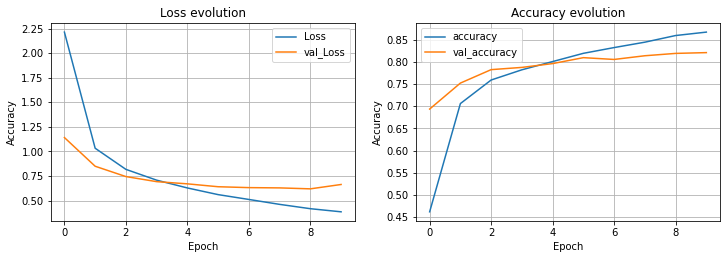

In [61]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [62]:
# predicted_classes = model.predict_classes(X_test)

In [63]:
predictions = np.argmax(model.predict(X_test), axis=-1)

In [64]:
# predictions = (model.predict(X_test) > 0.5).astype("int32")

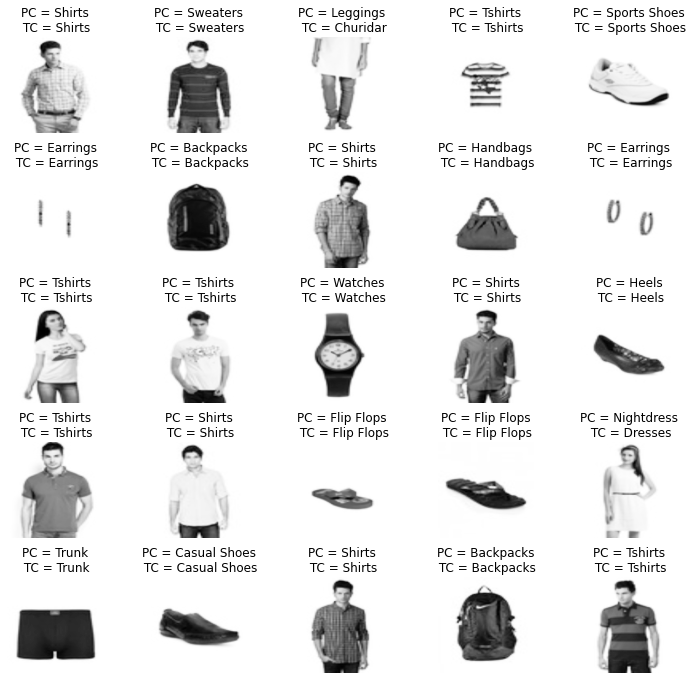

In [65]:
#PC=PredictedClass #TC=TrueClass
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(150,150), cmap='Greys_r')
    axes[i].set_title(f"PC = {unique_types[predictions[i]]}\n TC = {unique_types[Y_test[i]]}") #predicted_classes[i]:0.1f #Y_test[i]:0.1f
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [66]:
shortDataframe.head(10)

,filename,type,number_types
0,15970.jpg,Shirts,0
1,39386.jpg,Jeans,1
2,59263.jpg,Watches,2
3,21379.jpg,Track Pants,3
4,53759.jpg,Tshirts,4
5,1855.jpg,Tshirts,4
6,30805.jpg,Shirts,0
7,26960.jpg,Shirts,0
8,29114.jpg,Socks,5
9,30039.jpg,Watches,2


In [67]:
def load_image(i):
    Image_path=DATASET_PATH+list_directory[index]+"/"+shortDataframe.loc[i,'filename']
    Image_id=shortDataframe.loc[i,'filename'].split(".")
    res=Image_id[0]
    image = cv2.imread(Image_path,cv2.IMREAD_COLOR)
    resized_img = cv2.resize(image, dsize=(224, 224))
    return resized_img,res

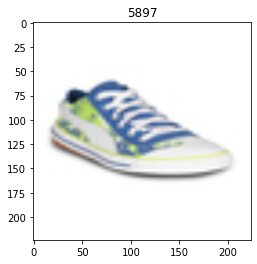

In [68]:
img,img_id = load_image(3500)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.title(img_id)
plt.imshow(img)

In [69]:
def make_prediction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    resized_img = cv2.resize(img, dsize=(150, 150))
    x_data = np.array(resized_img).reshape(-1, 150,150,1)
    x_data=x_data/255
#     print(x_data)
#     print(x_data.shape)
    result=model.predict(x_data)
#     print(type(result))
#     print(np.argmax(result))
    return x_data,unique_types[np.argmax(result)]

In [70]:
numpy_image,result=make_prediction(img)
print(result)

Casual Shoes


In [71]:
#df.head(10)

In [72]:
typeList=[]
for i, row in df.iterrows(): 
    if(row["articleType"]==result):
        #print(row["id"],row["articleType"])
        if(img_id!=str(row["id"])):
            typeList.append(row['id'])

In [73]:
print(typeList)

[9204, 39988, 22198, 29570, 26538, 49495, 19311, 49461, 23849, 24250, 15517, 4140, 6425, 42270, 32751, 39943, 22705, 50741, 20856, 19772, 5896, 49492, 9031, 59056, 15379, 19329, 39944, 36130, 44510, 22702, 30233, 6422, 12507, 42045, 24257, 15510, 20894, 40971, 7364, 13073, 39972, 16165, 22162, 17043, 10266, 4343, 47501, 22196, 23878, 26536, 54740, 13087, 32552, 39986, 12509, 23840, 24259, 18665, 20893, 9000, 50748, 11976, 3505, 13080, 32555, 39981, 15377, 5898, 22191, 26531, 6413, 11949, 5050, 22165, 49468, 10295, 22733, 13074, 39975, 22501, 37241, 3551, 42020, 4122, 21740, 3797, 44747, 14498, 38652, 23814, 17813, 18403, 12905, 5699, 24669, 47109, 44778, 39310, 31941, 13649, 34857, 33840, 3790, 44740, 7754, 2828, 13685, 26562, 6672, 21747, 20695, 6440, 24463, 3556, 8982, 37246, 2817, 33847, 2219, 49060, 31946, 54519, 18404, 12902, 23679, 17814, 34859, 41452, 3594, 50376, 44776, 17683, 3560, 5697, 53735, 14496, 4113, 26554, 44749, 9091, 6811, 30258, 14491, 26553, 53732, 47100, 4742, 569

In [74]:
i=0
X_similar=[]
X_id_similar=[]
X_numpy=[]
for imageId in typeList:
#     print(imageId)
    Image_path=DATASET_PATH+list_directory[index]+"/"+str(imageId)+".jpg"
    image = cv2.imread(Image_path,cv2.IMREAD_GRAYSCALE)
    try:
        resized_img = cv2.resize(image, dsize=(150,150))
    except:
        print("can't read file: ", str(imageId)+".jpg")
    X_similar.append(resized_img)
    X_id_similar.append(imageId)
        
X_numpy = np.array(X_similar).reshape(-1, 150,150,1)
X_numpy = X_numpy/255
#print(X_numpy[0])

Text(0.5, 1.0, '9204')

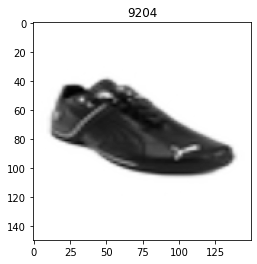

In [75]:
plt.imshow(X_similar[0], cmap='Greys_r')
plt.title(X_id_similar[0])

In [76]:
import math
def calculateDistance(i1, i2):
    return math.sqrt(np.sum((i1-i2)**2))

In [77]:
print(calculateDistance(numpy_image,X_numpy[0]))

41.868224282105835


In [78]:
distance_list=[]
for i in range (0, len(X_numpy)):
    distance_list.append(calculateDistance(numpy_image,X_numpy[i]))

sorted_distance_list=distance_list.copy()
#print(distance_list)
sorted_distance_list.sort()

least_ten_distance=sorted_distance_list[0:30]
print(least_ten_distance)
index_distance=[]
for i in range (0, len(least_ten_distance)-1):
    if(least_ten_distance[i]!=least_ten_distance[i+1]):
        index_distance.append(distance_list.index(least_ten_distance[i]))

index_distance=index_distance[0:15]

print(index_distance)

[14.636667968217411, 14.889406992884885, 15.375042314811287, 15.450076115670358, 15.502866002349784, 15.537385554379359, 15.652944492339989, 15.758966373011688, 15.761955179005396, 15.794739706107809, 15.801424412259895, 15.850904715985878, 15.89949111646027, 15.925102476558475, 16.001629578683378, 16.247993517622785, 16.375774720397047, 16.404297033667163, 16.41492695657277, 16.455512241248407, 16.471728251863237, 16.63957382709218, 16.645821797499515, 16.653192708129183, 16.666238056772542, 16.69858765527468, 16.726929575100765, 16.72981991173615, 16.77740420359604, 16.778994484222718]
[67, 2149, 1598, 1751, 65, 186, 1211, 1723, 1178, 1027, 2624, 529, 2509, 1333, 1902]


9204
39988
22198
29570
26538
49495
19311
49461
23849
24250
15517
4140
6425
42270
32751


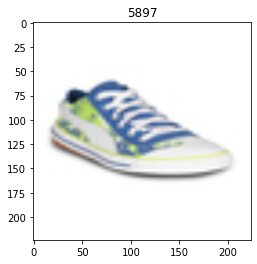

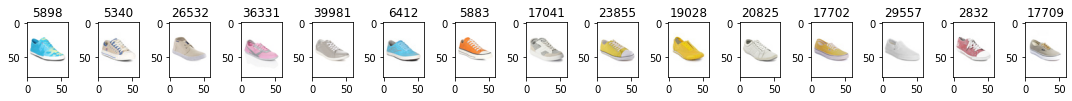

In [79]:
# Image_path=DATASET_PATH+list_directory[index]+"/"+str(img_id)+".jpg"
# src = cv2.imread(Image_path)
# image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
plt.imshow(img)
plt.title(img_id)

fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
axis=[]
for i in range(0,len(index_distance)):
    print(X_id_similar[i])
    Image_path=DATASET_PATH+list_directory[index]+"/"+str(X_id_similar[index_distance[i]])+".jpg"
    src = cv2.imread(Image_path)
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
    axis.append(fig.add_subplot(1,15, i+1))
    subplot_title=str(X_id_similar[index_distance[i]])
    axis[-1].set_title(subplot_title)  
    plt.imshow(image)

fig.tight_layout()
plt.show()

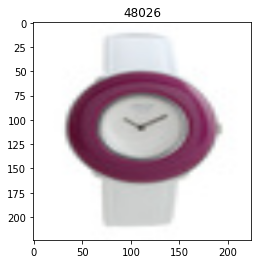

In [80]:
img,img_id = load_image(15500)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.title(img_id)
plt.imshow(img)

In [81]:
numpy_image,result=make_prediction(img)
print(result)

Watches


In [82]:
typeList=[]
for i, row in df.iterrows(): 
    if(row["articleType"]==result):
        #print(row["id"],row["articleType"])
        if(img_id!=str(row["id"])):
            typeList.append(row['id'])

In [83]:
# print(typeList)

In [84]:
i=0
X_similar=[]
X_id_similar=[]
X_numpy=[]
for imageId in typeList:
#     print(imageId)
    Image_path=DATASET_PATH+list_directory[index]+"/"+str(imageId)+".jpg"
    image = cv2.imread(Image_path,cv2.IMREAD_GRAYSCALE)
    try:
        resized_img = cv2.resize(image, dsize=(150,150))
    except:
        print("can't read file: ", str(imageId)+".jpg")
    X_similar.append(resized_img)
    X_id_similar.append(imageId)
        
X_numpy = np.array(X_similar).reshape(-1, 150,150,1)
X_numpy = X_numpy/255
#print(X_numpy[0])



Text(0.5, 1.0, '59263')

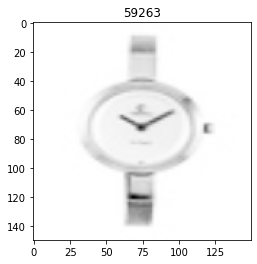

In [85]:
plt.imshow(X_similar[0], cmap='Greys_r')
plt.title(X_id_similar[0])

In [86]:
print(calculateDistance(numpy_image,X_numpy[0]))

41.928142333871605


In [87]:
distance_list=[]
for i in range (0, len(X_numpy)):
    distance_list.append(calculateDistance(numpy_image,X_numpy[i]))

sorted_distance_list=distance_list.copy()
#print(distance_list)
sorted_distance_list.sort()

least_ten_distance=sorted_distance_list[0:30]
print(least_ten_distance)
index_distance=[]
for i in range (0, len(least_ten_distance)-1):
    if(least_ten_distance[i]!=least_ten_distance[i+1]):
        index_distance.append(distance_list.index(least_ten_distance[i]))

index_distance=index_distance[0:15]

print(index_distance)

[20.414826765482665, 21.868481442121, 23.000139076523165, 23.042434151501823, 23.07608930758506, 23.83319194028118, 24.354268537600095, 24.37018365945444, 24.53853500344591, 24.642463265080814, 24.686960696906286, 24.77140176194771, 25.03576803079875, 25.079497133526985, 25.61315231874419, 25.64891640451648, 25.819117940221595, 25.956130143793057, 26.328528900487804, 26.34973865928339, 26.692263090288908, 26.814574528623343, 27.13039412310286, 27.308742419482464, 27.41656049382933, 27.47677583530734, 27.48929399096113, 27.6310931511479, 27.694671003628677, 27.8484670402817]
[239, 1956, 325, 2193, 1107, 1812, 2159, 1055, 2075, 1858, 569, 1565, 2061, 109, 836]


59263
30039
29928
17429
51658
23278
44984
11188
45258
44970
22950
13841
8110
43190
32335


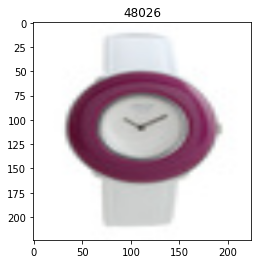

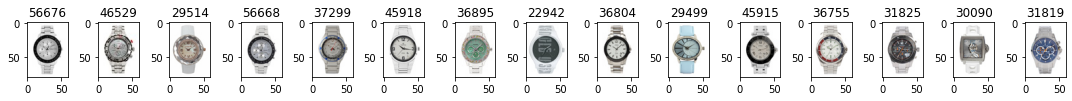

In [88]:
plt.imshow(img)
plt.title(img_id)

fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
axis=[]
for i in range(0,len(index_distance)):
    print(X_id_similar[i])
    Image_path=DATASET_PATH+list_directory[index]+"/"+str(X_id_similar[index_distance[i]])+".jpg"
    src = cv2.imread(Image_path)
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
    axis.append(fig.add_subplot(1,15, i+1))
    subplot_title=str(X_id_similar[index_distance[i]])
    axis[-1].set_title(subplot_title)  
    plt.imshow(image)

fig.tight_layout()
plt.show()

In [89]:
# shortDataframe.to_csv('/content/drive/MyDrive/Colab Notebooks/Final project/shortDataframe.csv')

In [90]:
model.save("/content/drive/MyDrive/Colab Notebooks/Final project/my_model_2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final project/my_model_2/assets


In [91]:
# model.save("/content/drive/MyDrive/Colab Notebooks/Final project/my_h5_model.h5")

In [92]:
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/Final project/my_model_Weights')


In [93]:
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/Final project/my_h5_model_Weights.h5')